In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import jetsimpy 
from astropy.cosmology import Planck15 as cosmo

def jetsim_params(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, nu):
    dl = cosmo.luminosity_distance(z).to("Mpc").value
    P = dict(
        eps_e=10 ** logepse,
        eps_b=10 ** logepsb,
        p=p,
        theta_v=thv,
        d=dl,
        z=z,
    )
    
    jet_P = dict(
        Eiso=10 ** loge0,
        lf=lf,  # no coasting phase
        theta_c=thc,
        n0=10 ** logn0,
        A=A,  # no wind
        s=s,
    )
    return P, jet_P

def model(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, nu):
    #print(f"Luminosity distance: {dl} Mpc")
    
    P, jet_P = jetsim_params(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, nu)
    # TODO: Ignoring jetType
    jet = jetsimpy.Jet(
        jetsimpy.PowerLaw(
            jet_P["theta_c"], jet_P["Eiso"], lf0=jet_P["lf"], s=jet_P["s"]
        ),
        nwind=jet_P["A"],
        nism=jet_P["n0"],
        grid=jetsimpy.ForwardJetRes(jet_P["theta_c"], 129),
        # allow spread or not
        spread=True,
        tmin=10.0,
        tmax=3.2e9,
        tail=True,
        cal_level=1,
        rtol=1e-6,
        cfl=0.9,
    )
    
    model_flux = jet.FluxDensity(
        t,  # [second]
        nu,  # [Hz]
        P,
        model="sync",  # radiation model
        rtol=1e-3,  # integration tolerance
        max_iter=100,
        force_return=True,
    )
    return model_flux

def append_ztext(z_text, key, value):
    if key in ['specType', 'z', 'E0']:
        return z_text
        # Skip function objects, just show the key
        #z_text += f"{key}: {type(value).__name__}\n"
    else:
        z_text += '\n'
        # Format numerical values
        if isinstance(value, (int, float)):
            if abs(value) >= 1e6 or (abs(value) < 1e-3 and value != 0):
                    z_text += f"{key}: {value:.2e}"
            else:
                    z_text += f"{key}: {value:.4f}"
        else:
            z_text += f"{key}: {value}"
    return z_text

multipliers = {'X-ray': 1.0, 'g': 0.125, 'r': 1, 'i': 8.0, 'z': 16.0, 'J': 32.0, 'radio(1.3GHz)': 100.0, 'radio(6GHz)': 400, 'radio(10GHz)': 1500}
def lc_plot(
        jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf=300, A=0, s=6):
    # Time and Frequencies
    ta = 600
    tb = 1.0e2 * 86400
    t = np.geomspace(ta, tb, num=100)

    df_allobs = pd.read_csv(observed_data)
    df_fit = None
    #if observed_data_fit is not None:
        #df_fit=pd.read_csv(observed_data_fit)

    frequencies = df_allobs[['Filt','Freqs']].drop_duplicates().sort_values(by='Freqs').to_numpy()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'
    colors = cmap(np.linspace(0, 1, len(frequencies)))

    for i, (band,nu) in enumerate(frequencies):
        print(f'')
        if band in multipliers: multiplier = multipliers[band]
        else: continue
        print(f"Calculating for frequency: {nu}")
        
    if df_fit is not None:
        for i, (band,nu) in enumerate(frequencies):
            Fnu_fit = df_fit[df_fit['Filt']==band][['Times','Fluxes', 'FluxErrs']].sort_values(by='Times').to_numpy()
            ax.scatter(Fnu_fit[:,0], Fnu_fit[:,1]*multiplier, marker='o', s=36, color=colors[i], edgecolors='black',
            linewidths=1,zorder=100)

    #ax.tick_params(axis="both",direction="in")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F_\nu$ (mJy)')
    # Add major and minor ticks with grid
    ax.tick_params(axis="both", which="major", direction="in", length=6, width=1.5)
    ax.tick_params(axis="both", which="minor", direction="in", length=3, width=1.0)
    ax.grid(True, which="major", alpha=0.5, linestyle="-", linewidth=0.8)
    ax.grid(True, which="minor", alpha=0.3, linestyle=":", linewidth=0.5)
    
    # Create text content with all Z dictionary values
    # Get all function parameters as a dictionary
    P, jet_P = jetsim_params(jetType, loge0, logepsb, logepse, logn0, thc, thv, p, z,
        observed_data, observed_data_fit,lf, A, s, t, nu)

    z_text = ''
    for key, value in P.items():
        z_text = append_ztext(z_text, key, value)
    
    for key, value in jet_P.items():
        z_text = append_ztext(z_text, key, value)

    # Add textbox with all Z dictionary values
    ax.text(0.98, 0.02, z_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.5, edgecolor='none'),
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, fontfamily='monospace')
    
    #marker_text = "*  Observations used for fitting\nx  All observations\nDashed lines show the best fit"
    #ax.text(0.2, 0.02, marker_text, transform=ax.transAxes, 
    #        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor="black"),
    #        verticalalignment='bottom', fontsize=10, fontfamily='monospace')
    
    ax.legend(edgecolor='none', loc="lower left", ncol=2)
    fig.tight_layout()

    print("Saving plots/lc_afterflow_obs_matching.pdf")
    fig.savefig("plots/lc_afterflow_obs_matching.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_35370/1812237497.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'
/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_35370/1812237497.py:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(edgecolor='none', loc="lower left", ncol=2)






Saving plots/lc_afterflow_obs_matching.pdf


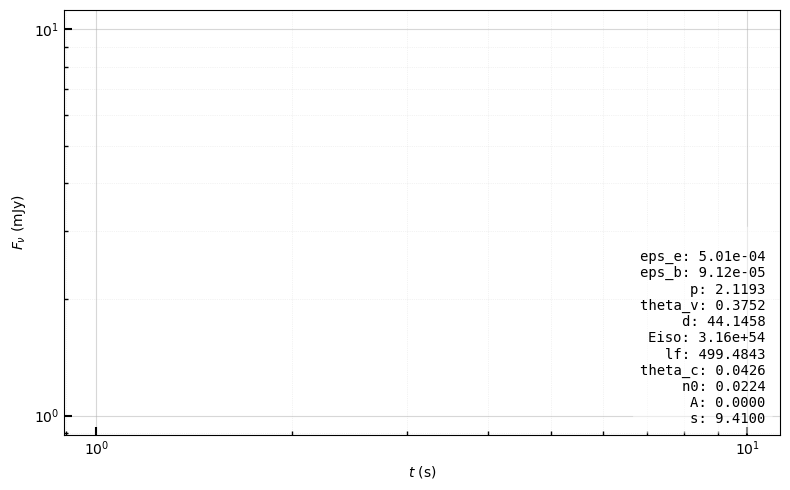

In [13]:


lc_plot(jetType='powerlaw',
    loge0=54.5, logepsb=-4.04, logepse=-3.3, logn0=-1.65, thc=2.44*np.pi/180, 
    thv=21.5*np.pi/180, lf=499.48430323,
    s=9.41, p=2.1193,
    z=0.0099,
    observed_data='data/GW170817.csv',
    observed_data_fit='data/GW170817.csv')#)'data/mcmc_df_trunc.csv',)

# powerlaw jet

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2880382543.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


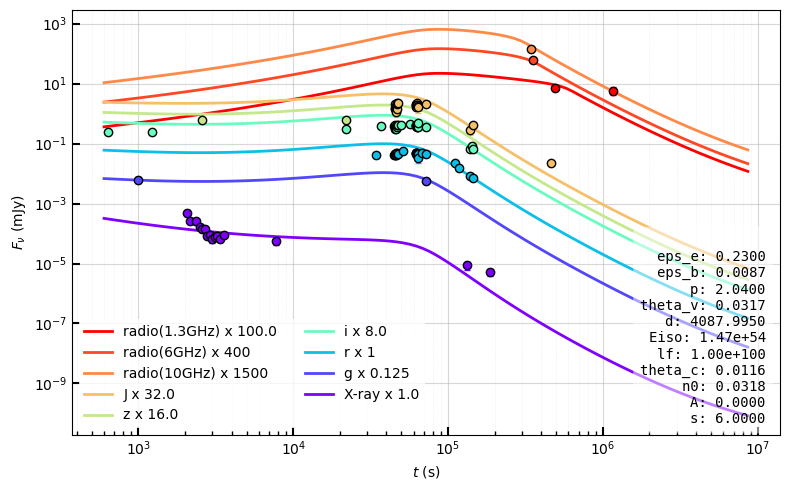

In [56]:
"""{'eps_e': 0.1,
 'eps_b': np.float64(0.0010672746044513245),
 'p': np.float64(2.3982555703436303),
 'theta_v': np.float64(0.02622135291403654),
 'd': np.float64(4087.9949915089733),
 'z': 0.661,
 'Eiso': np.float64(3.5069730984908385e+54),
 'lf': 1e+100,
 'theta_c': np.float64(0.00930170689709683),
 'n0': np.float64(0.007406762477161884),
 'A': 0,
 's': 6}"""
lc_plot(jetType='powerlaw',
    loge0=np.log10(1.47e+54), logepsb=np.log10(0.00875), s=6, 
    logn0=np.log10(0.0318), thc=0.0116, thv=0.0317,
    p=2.04, logepse=np.log10(0.23),A=0, z=0.661, lf=1e100,
    observed_data='data/mcmc_df.csv',
    observed_data_fit='data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


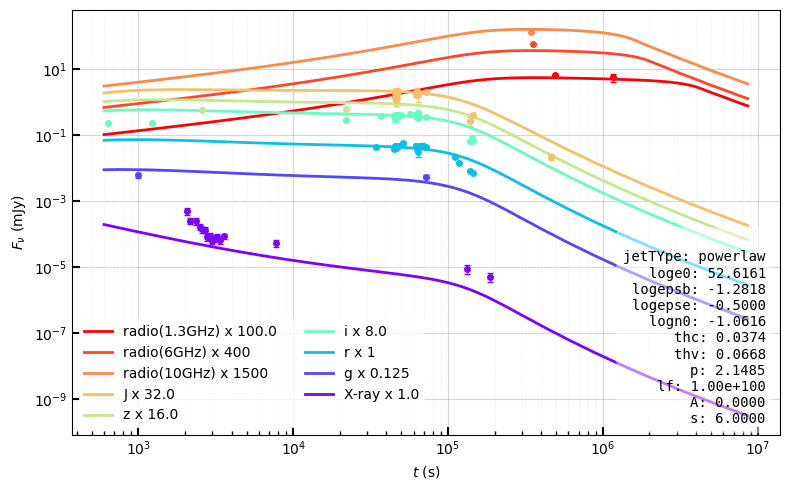

In [10]:

lc_plot(jetType='powerlaw',
    loge0=52.616085944159316, logepsb=-1.2817950618670402, s=6.0, 
    logn0=-1.0615603629426942, thc=0.03738114324346451, thv=0.06675981254963001, p=2.148516064908085,
    logepse=-0.5000044643265977,lf=1e+100,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit='data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


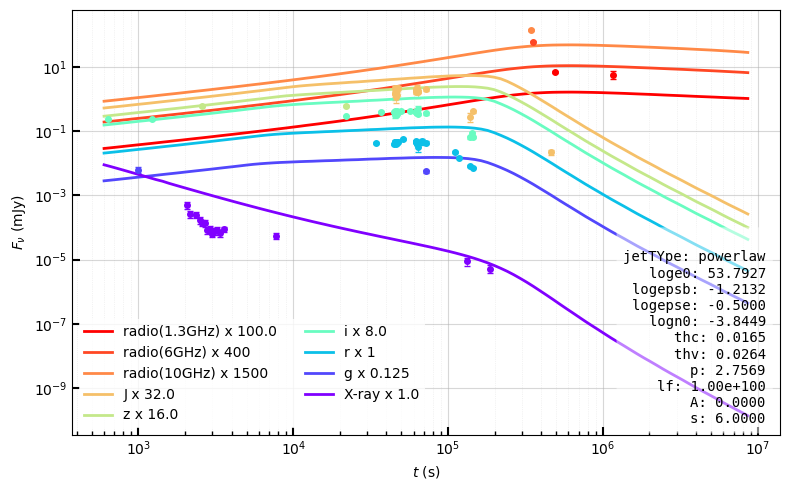

In [11]:
lc_plot(jetType='powerlaw',
    loge0=53.79274778, logepsb=-1.21321178, logn0=-3.84493855, thc=0.01651769, 
    thv=0.02637001, p=2.75691902,
    logepse=-0.5000044643265977,lf=1e+100,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit='data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


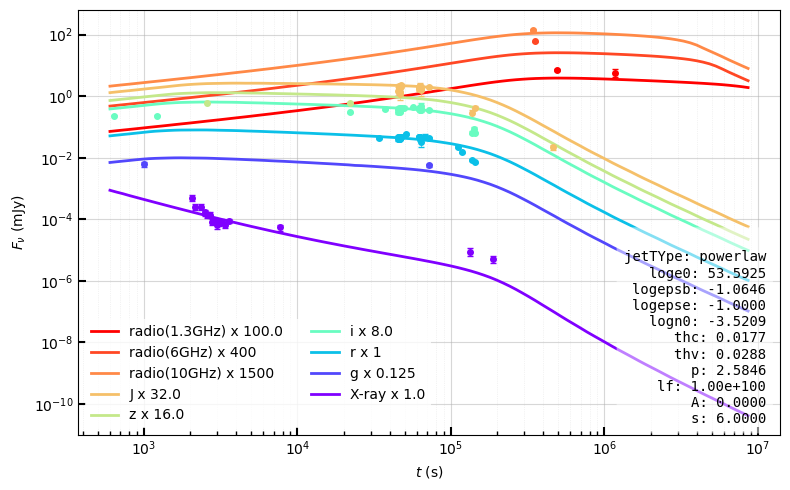

In [12]:


lc_plot(jetType='powerlaw',
    loge0=53.59246942, logepsb=-1.06455466, logn0=-3.52086857, thc=0.01772557, thv=0.02884210, p=2.58457125,
    s=6.0, logepse=-1.0,lf=1e+100,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit=None)#)'data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


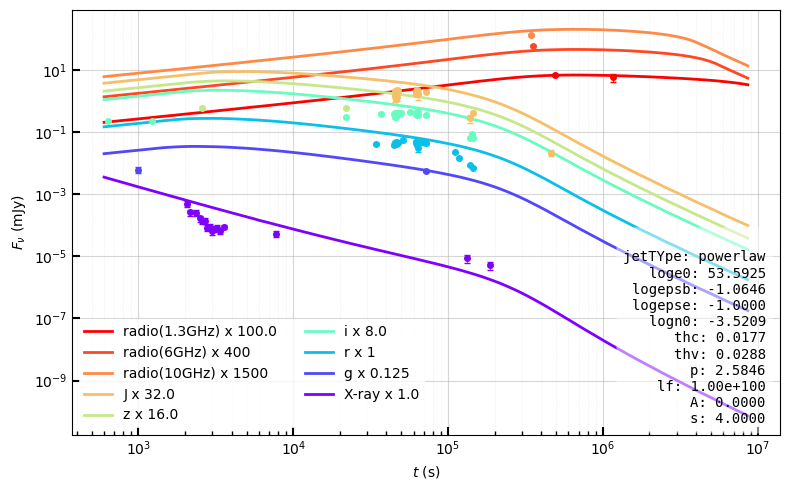

In [13]:

lc_plot(jetType='powerlaw',
    loge0=53.59246942, logepsb=-1.06455466, logn0=-3.52086857, thc=0.01772557, thv=0.02884210, p=2.58457125,
    s=4.0, logepse=-1.0,lf=1e+100,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit=None)#)'data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


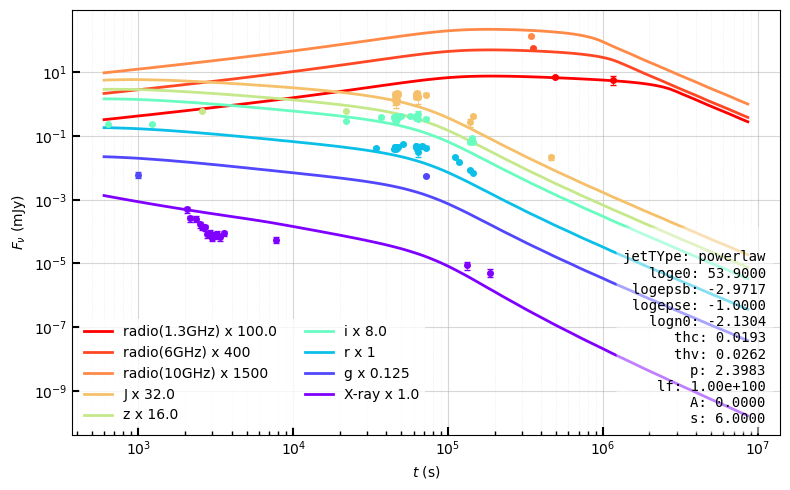

In [14]:

lc_plot(jetType='powerlaw',
    loge0=53.9, logepsb=-2.971723824386026, logn0=-2.130371582243492, thc=0.01930170689709683, 
    thv=0.02622135291403654, p=2.3982555703436303,
    s=6.0, logepse=-1.0,lf=1e100,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit=None)#)'data/mcmc_df_trunc.csv',)

/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_54293/2747484951.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow_r')  # or 'plasma', 'cividis', 'magma'


Saving plots/lc_afterflow_obs_matching.pdf


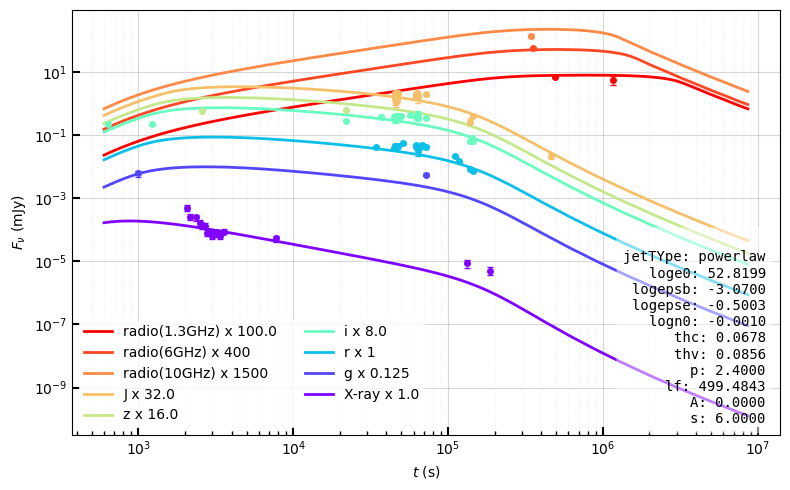

In [15]:


lc_plot(jetType='powerlaw',
    loge0=52.81987601, logepsb=-3.07001529, logepse=-0.50031916, logn0=-0.00100200, thc=0.06776206, 
    thv=0.08558995, lf=499.48430323,
    s=6.0, p=2.4,
    z=0.661,
    observed_data='data/mcmc_df.csv',
    observed_data_fit=None)#)'data/mcmc_df_trunc.csv',)